In [1]:
import torch
import torchaudio
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchaudio.transforms import MelSpectrogram

import os
import re
import random
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from pprint import pprint
from IPython.display import Audio
from scipy.io import wavfile

from bark.bark import SAMPLE_RATE, generate_audio, preload_models

d:\Code\大學\人工智慧概論\期末計劃 - 聲音辨識\.venv\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
def save_history(basepath: str, audio_array: np.ndarray, prompt: str, generation_data: list):
  np.savez(f"{basepath}.npz", semantic_prompt=generation_data[0], coarse_prompt=generation_data[1], fine_prompt=generation_data[2])
  with open(f"{basepath}.txt", "w", encoding="utf-8") as fp: fp.write(prompt)
  wavfile.write(f"{basepath}.wav", SAMPLE_RATE, audio_array)

def load_history(filepath: str):
  return np.load(filepath)

def load_voice(filepath: str):
  sample_rate, audio_array = wavfile.read(filepath)
  return audio_array

def display_spectrogram(audio_array: np.ndarray):
  plt.specgram(audio_array, NFFT=400, Fs=SAMPLE_RATE)
  plt.show()

In [23]:
NUM_EPOCHS = 1
NUM_STEPS = 10000

BATCH_SIZE = 4

DURATION = 3000
SHIFT = 10

EMBEDDING_DIM = int(DURATION * SAMPLE_RATE / 1000)

In [18]:
class VoiceDataset(Dataset):
  def __init__(self, directory, embedding_dim = EMBEDDING_DIM):
    super().__init__()
    self.k = 1
    self.num_mels = 64
    self.population = 0
    self.length = 0
    self.embedding_dim = embedding_dim
    self.voices = []
    self.base_map = {}
    self.ms = MelSpectrogram(SAMPLE_RATE, n_mels=self.num_mels)
    for filename in os.listdir(directory):
      if not filename.endswith(".wav"): continue
      self.voices.append([])
      self.population += 1
      folder_name = filename.split(".wav")[0]
      self.base_map[folder_name] = self.population
      for fn in os.listdir(f"./data/bark/{folder_name}"):
        if not fn.endswith(".wav"): continue
        self.voices[-1].append(torch.tensor(load_voice(f"./data/bark/{folder_name}/{fn}"), dtype=torch.float))
        self.length += 1

  def __getitem__(self, _):
    samples, targets, labels = [], [], torch.zeros(len(self.voices) * self.k)
    r_index = random.randint(0, len(self.voices) - 1)
    labels[r_index] = 1
    for person in self.voices:
      for s in random.choices(person, k=self.k):
        r = random.randint(0, len(s) - self.embedding_dim)
        samples.append(self.ms(s[r:r + self.embedding_dim]).numpy())
      for t in random.choices(self.voices[r_index], k=self.k):
        r = random.randint(0, len(t) - self.embedding_dim)
        targets.append(self.ms(t[r:r + self.embedding_dim]).numpy())
    samples = torch.tensor(np.concatenate(samples)).view(len(self.voices) * self.k, self.num_mels, -1).float()
    targets = torch.tensor(np.concatenate(targets)).view(len(self.voices) * self.k, self.num_mels, -1).float()
    return samples, targets, labels

  def get_selected(self, target):
    samples, targets = [], []
    for person in self.voices:
      for s in random.choices(person, k=self.k):
        r = random.randint(0, len(s) - self.embedding_dim)
        samples.append(self.ms(s[r:r + self.embedding_dim]).numpy())
        r = random.randint(0, len(target) - self.embedding_dim)
        targets.append(self.ms(torch.tensor(target[r:r + self.embedding_dim]).float()).numpy())
    samples = torch.tensor(np.concatenate(samples)).view(len(self.voices) * self.k, self.num_mels, -1).float()
    targets = torch.tensor(np.concatenate(targets)).view(len(self.voices) * self.k, self.num_mels, -1).float()
    return samples, targets

  def __len__(self): return self.length

In [19]:
dataset = VoiceDataset("./data/bark")
# torch.save(dataset, "./checkpoints/bark_dataset.pt")

In [20]:
# dataset = torch.load("./checkpoints/bark_dataset.pt")
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, drop_last=True)

In [95]:
class Judge(nn.Module):
  def __init__(self):
    super().__init__()
    self.seq1 = nn.Sequential(
      nn.Conv2d(1, 64, 4, 2, 1),
      nn.BatchNorm2d(64),
      nn.MaxPool2d(4),
      nn.ReLU(True),
      nn.Conv2d(64, 128, 2),
      nn.BatchNorm2d(128),
      nn.MaxPool2d(2),
      nn.ReLU(True),
      nn.Conv2d(128, 256, 2),
      nn.BatchNorm2d(256),
      nn.MaxPool2d(2),
      nn.ReLU(True),
      nn.Flatten(),
      nn.Dropout(0.3)
    )
    self.seq2 = nn.Sequential(
      nn.Linear(256 * 20, 256),
      nn.ReLU(True),
      nn.Linear(256, 64),
      nn.ReLU(True),
      nn.Linear(64, 1),
      nn.Sigmoid(),
    )

  def forward(self, sample, target):
    outputs1 = self.seq1(sample.view(sample.size(0), 1, sample.size(1), sample.size(2)))
    outputs2 = self.seq1(target.view(sample.size(0), 1, sample.size(1), sample.size(2)))
    outputs = self.seq2(torch.cat((outputs1, outputs2), dim=1))
    return outputs

class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.judge = Judge()
    self.softmax = nn.Softmax(dim=1)

  def forward(self, samples, targets):
    outputs = []
    for s, t in zip(samples, targets): outputs.append(self.judge(s, t))
    outputs = torch.cat(tuple(outputs), dim=1).permute(1, 0)
    outputs = self.softmax(outputs)
    return outputs

In [ ]:
samples, targets, labels = next(iter(dataloader))
model = Judge()
plt.plot(np.arange(0, 3, 1 / SAMPLE_RATE), samples[0][0].numpy())
plt.show()
plt.plot(np.arange(0, 3, 1 / SAMPLE_RATE), samples[0][1].numpy())
plt.show()
plt.plot(np.arange(0, 3, 1 / SAMPLE_RATE), samples[0][2].numpy())
plt.show()
plt.plot(np.arange(0, 3, 1 / SAMPLE_RATE), targets[0][0].numpy())
plt.show()
print(model(samples[0], targets[0]))
print(model(samples[1], targets[1]))

In [96]:
samples, targets, labels = next(iter(dataloader))
model = Model()
loss_fn = nn.CrossEntropyLoss()
outputs = model(samples, targets)
print(samples.shape, targets.shape)
print(outputs)
print(labels)
print(loss_fn(outputs, labels))

torch.Size([4, 10, 64, 361]) torch.Size([4, 10, 64, 361])
tensor([[0.1032, 0.0972, 0.0976, 0.1022, 0.0935, 0.1025, 0.1000, 0.0988, 0.1023,
         0.1027],
        [0.0991, 0.1026, 0.1016, 0.0975, 0.1005, 0.0976, 0.1013, 0.1012, 0.0985,
         0.1001],
        [0.1021, 0.0960, 0.0984, 0.1013, 0.1020, 0.1028, 0.0978, 0.0976, 0.1030,
         0.0989],
        [0.1022, 0.0930, 0.0970, 0.1035, 0.1012, 0.1032, 0.1013, 0.0999, 0.1019,
         0.0967]], grad_fn=<SoftmaxBackward0>)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])
tensor(2.3015, grad_fn=<DivBackward1>)


In [97]:
torch.backends.cudnn.benchmark = True
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Model(dataset.k)
optimizer = optim.Adam(model.parameters(), lr=3e-5, weight_decay=1e-5)
loss_fn = nn.CrossEntropyLoss()
losses = []
display_losses = []

model.train()

if device == "cuda": model.cuda()
for step in range(1, NUM_STEPS + 1):
  optimizer.zero_grad()
  samples, targets, labels = next(iter(dataloader))
  outputs = model(samples.to(device), targets.to(device))
  loss = loss_fn(outputs.to(device), labels.to(device))
  losses.append(loss.item())
  loss.backward()
  optimizer.step()
  if step % 100 == 0:
    display_losses.append(np.mean(losses))
    print(f"{step}/{NUM_STEPS}:\t{display_losses[-1]:.4f}")
    losses = []
print("Training Ended!")
plt.plot(display_losses)
plt.show()

100/10000:	2.3025
200/10000:	2.3023
300/10000:	2.3027
400/10000:	2.3027
500/10000:	2.3019
600/10000:	2.3014
700/10000:	2.3009
800/10000:	2.3003
900/10000:	2.3007
1000/10000:	2.2987
1100/10000:	2.2963
1200/10000:	2.2975
1300/10000:	2.2974
1400/10000:	2.2948
1500/10000:	2.2944
1600/10000:	2.2906
1700/10000:	2.2926
1800/10000:	2.2881
1900/10000:	2.2887
2000/10000:	2.2873
2100/10000:	2.2859
2200/10000:	2.2870
2300/10000:	2.2846
2400/10000:	2.2888
2500/10000:	2.2853
2600/10000:	2.2811
2700/10000:	2.2818
2800/10000:	2.2786
2900/10000:	2.2781
3000/10000:	2.2793
3100/10000:	2.2751
3200/10000:	2.2784
3300/10000:	2.2730
3400/10000:	2.2736
3500/10000:	2.2697
3600/10000:	2.2739
3700/10000:	2.2760
3800/10000:	2.2692
3900/10000:	2.2709
4000/10000:	2.2741
4100/10000:	2.2695
4200/10000:	2.2694
4300/10000:	2.2706
4400/10000:	2.2686
4500/10000:	2.2695
4600/10000:	2.2700
4700/10000:	2.2690
4800/10000:	2.2664
4900/10000:	2.2667
5000/10000:	2.2644
5100/10000:	2.2641
5200/10000:	2.2639
5300/10000:	2.2656
54

In [44]:
with torch.no_grad():
  t = load_voice("./data/bark/woman-2.wav")
  samples, targets = dataset.get_selected(t)
  outputs = model(samples.to(device).unsqueeze(0), targets.to(device).unsqueeze(0))
  print(np.round(outputs.cpu().numpy(), 3))
  print(outputs.cpu().numpy().argmax() + 1)
  pprint(dataset.base_map)
  display(Audio(samples[0], rate=SAMPLE_RATE))
  display(Audio(targets[0], rate=SAMPLE_RATE))
  display(Audio(samples[1], rate=SAMPLE_RATE))
  display(Audio(targets[1], rate=SAMPLE_RATE))
  display(Audio(samples[2], rate=SAMPLE_RATE))
  display(Audio(targets[2], rate=SAMPLE_RATE))

[[0.333 0.333 0.333]]
3
{'man-1': 1, 'woman-1': 2, 'woman-2': 3}


100%|██████████| 1000/1000 [00:16<00:00, 60.32it/s]


array([[0.13813809, 0.06717523, 0.06748996, 0.10305639, 0.14114464,
        0.08084018, 0.10973981, 0.14176277, 0.07677282, 0.07388011]])

array([238.,   1.,   2.,  87., 274.,  23.,  90., 271.,  10.,   4.])

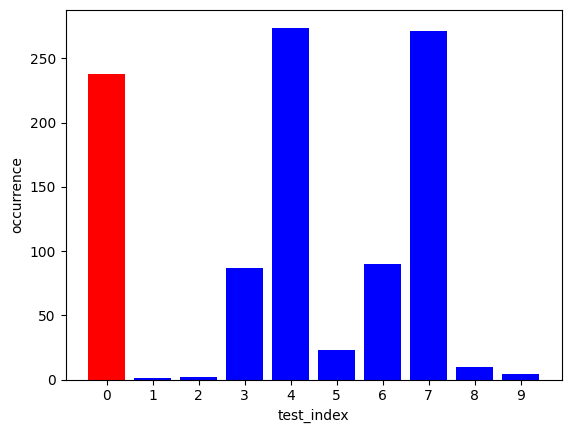

100%|██████████| 1000/1000 [00:17<00:00, 57.61it/s]


array([[0.07997008, 0.18770108, 0.18249136, 0.08304949, 0.07900899,
        0.08725868, 0.07490577, 0.07591419, 0.07487133, 0.07482902]])

array([  4., 496., 488.,   2.,   4.,   6.,   0.,   0.,   0.,   0.])

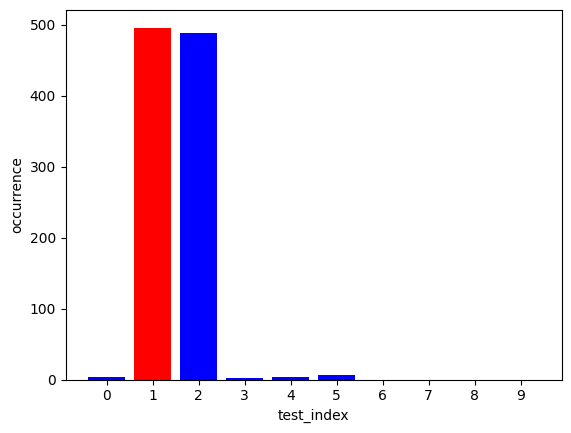

100%|██████████| 1000/1000 [00:18<00:00, 52.88it/s]


array([[0.07525568, 0.19747287, 0.19383286, 0.07791248, 0.07536009,
        0.08170703, 0.07457952, 0.0747216 , 0.07457894, 0.07457894]])

array([  0., 447., 552.,   1.,   0.,   0.,   0.,   0.,   0.,   0.])

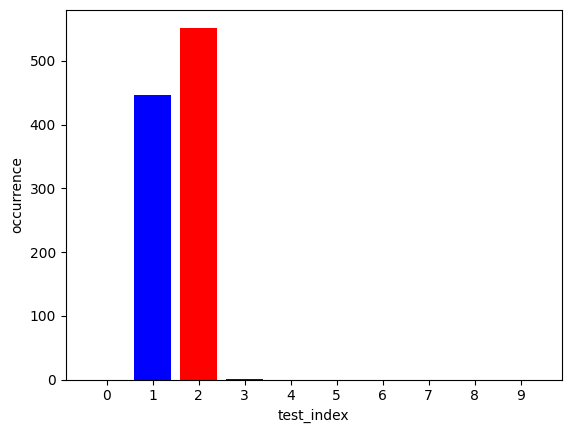

100%|██████████| 1000/1000 [00:18<00:00, 53.22it/s]


array([[0.09454668, 0.10455565, 0.09565725, 0.15402356, 0.09316018,
        0.14770566, 0.07625578, 0.08278187, 0.07570917, 0.07560421]])

array([ 49.,  99.,  56., 398.,  48., 337.,   0.,  13.,   0.,   0.])

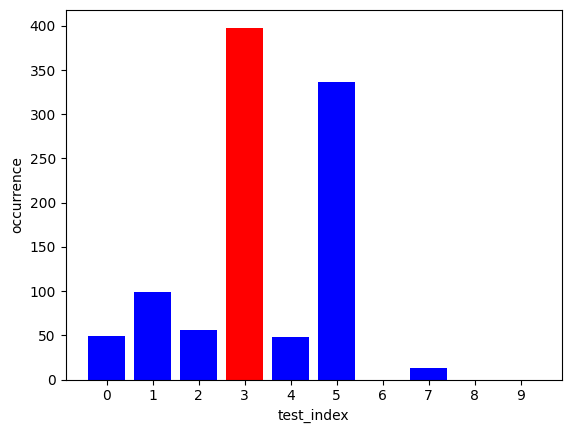

100%|██████████| 1000/1000 [00:18<00:00, 53.23it/s]


array([[0.11079494, 0.09596126, 0.0894265 , 0.14745351, 0.11020515,
        0.12564921, 0.07845022, 0.0947596 , 0.07368885, 0.07361076]])

array([146.,  86.,  50., 317., 153., 195.,   7.,  46.,   0.,   0.])

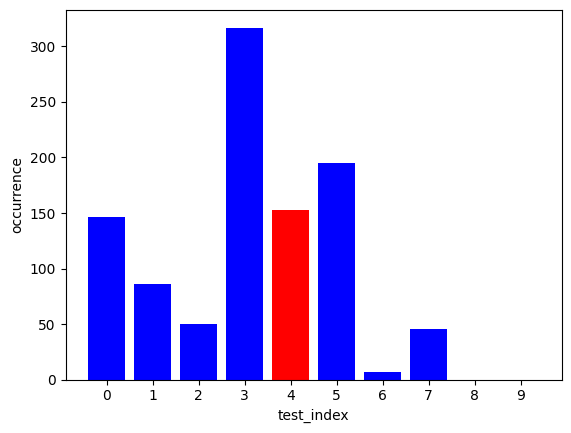

100%|██████████| 1000/1000 [00:19<00:00, 52.03it/s]


array([[0.08136423, 0.1409101 , 0.12935787, 0.12285499, 0.08219773,
        0.14123747, 0.07505302, 0.07733572, 0.07484419, 0.07484467]])

array([ 18., 316., 216., 167.,  26., 251.,   1.,   5.,   0.,   0.])

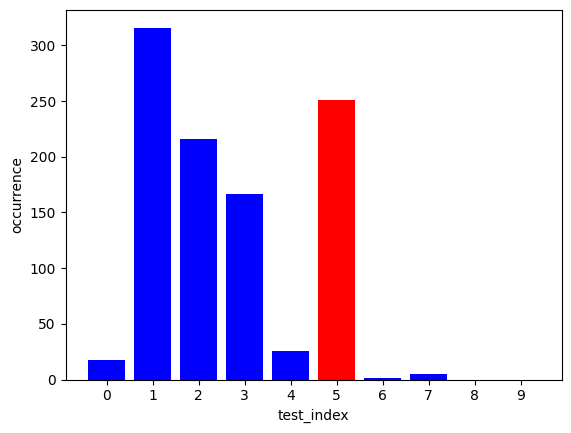

100%|██████████| 1000/1000 [00:18<00:00, 53.74it/s]


array([[0.12227898, 0.09790069, 0.09414291, 0.11429159, 0.12059041,
        0.10042064, 0.08722098, 0.10400856, 0.07998673, 0.0791585 ]])

array([227., 117.,  80., 170., 202.,  91.,  22.,  86.,   4.,   1.])

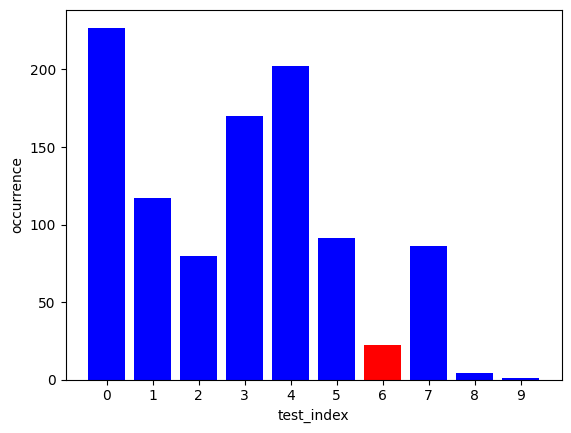

100%|██████████| 1000/1000 [00:18<00:00, 52.97it/s]


array([[0.12845848, 0.07884343, 0.07696756, 0.14022841, 0.12561703,
        0.10815563, 0.08340293, 0.11214325, 0.07321519, 0.07296808]])

array([226.,  19.,   8., 268., 217., 127.,  13., 122.,   0.,   0.])

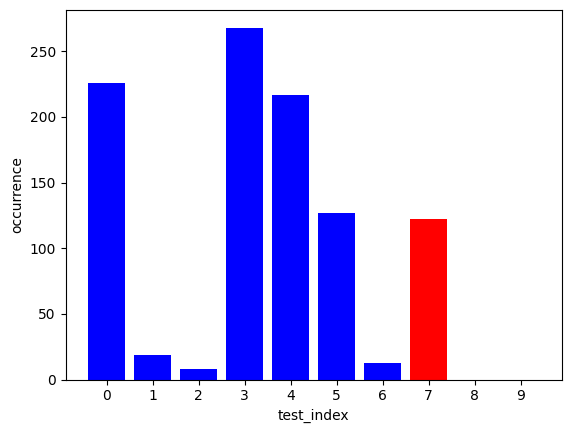

100%|██████████| 1000/1000 [00:18<00:00, 52.64it/s]


array([[0.09040812, 0.06684823, 0.06750261, 0.06864519, 0.09191132,
        0.06847058, 0.12956592, 0.0980337 , 0.15873199, 0.15988234]])

array([ 27.,   1.,   4.,   1.,  30.,   3., 124.,  28., 340., 442.])

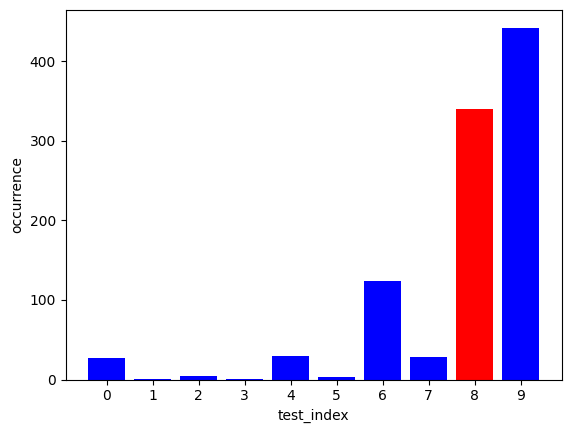

100%|██████████| 1000/1000 [00:18<00:00, 52.75it/s]


array([[0.11256036, 0.06593152, 0.06637413, 0.06934479, 0.11156202,
        0.06772207, 0.13780953, 0.11713483, 0.12689323, 0.12466752]])

array([ 76.,   5.,   5.,   1.,  86.,   5., 249.,  79., 255., 239.])

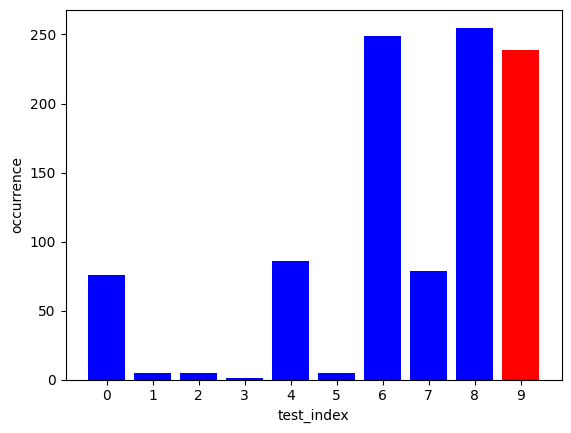

In [98]:
num_validation = 1000
test_cases = ["man-1", "man-2", "man-3", "man-4", "man-5", "woman-1", "woman-2", "woman-3", "woman-4", "woman-5"]

with torch.no_grad():
  for test_index in range(len(dataset.voices)):
    colors = ["b" if i != test_index else "r" for i in range(len(dataset.voices))]
    avg = np.zeros((1, len(dataset.voices)))
    occurrences = np.zeros(len(dataset.voices))
    for i in tqdm(range(num_validation)):
      t = load_voice(f"./data/bark/{test_cases[test_index]}.wav")
      samples, targets = dataset.get_selected(t)
      outputs = model(samples.to(device).unsqueeze(0), targets.to(device).unsqueeze(0))
      avg += outputs.cpu().numpy()
      occurrences[outputs.cpu().numpy().argmax()] += 1
    display(avg / num_validation)
    display(occurrences)
    plt.bar(np.arange(len(dataset.voices)), occurrences, color=colors)
    plt.xticks(range(len(dataset.voices)))
    plt.xlabel("test_index")
    plt.ylabel("occurrence")
    plt.show()
  # display(Audio(samples[0], rate=SAMPLE_RATE))
  # display(Audio(targets[0], rate=SAMPLE_RATE))
  # display(Audio(samples[1], rate=SAMPLE_RATE))
  # display(Audio(targets[1], rate=SAMPLE_RATE))
  # display(Audio(samples[2], rate=SAMPLE_RATE))
  # display(Audio(targets[2], rate=SAMPLE_RATE))

In [8]:
def generate(basename, raw_prompt, index):
  basepath = "./data/bark/"
  text_prompt = re.sub(r"\s\s+", " ", re.sub(r"[\t\n]", "", raw_prompt)).strip()
  print(f"{basename}: prompt-{index}")
  audio_array, generation_data = generate_audio(text_prompt, basename)
  if basename not in os.listdir(basepath): os.mkdir(f"{basepath}/{basename}")
  save_history(f"{basepath}/{basename}/prompt-{index}", audio_array, text_prompt, generation_data)

In [ ]:
preload_models(use_smaller_models=True)

In [9]:
raw_prompts = [
  "A pessimist is one who makes difficulties of his opportunities and an optimist is one who makes opportunities of his difficulties.",
  "Don't judge each day by the harvest you reap but by the seeds that you plant.",
  "Challenges are what make life interesting and overcoming them is what makes life meaningful.",
  "Happiness lies not in the mere possession of money; it lies in the joy of achievement, in the thrill of creative effort.",
  "I disapprove of what you say, but I will defend to the death your right to say it.",
  "If I looked compared to others far, is because I stand on giant's shoulder.",
  "Never argue with stupid people, they will drag you down to their level and then beat you with experience.",
  "The greatest glory in living lies not in never falling, but in rising every time we fall.",
  "When you look into the abyss, the abyss also looks into you.",
  "Whoever fights monsters should see to it that in the process he does not become a monster."
]

basename = "woman-2"

for i, raw_prompt in enumerate(raw_prompts):
  generate(basename, raw_prompt, i)

woman-2: prompt-0
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 26/26 [00:25<00:00,  1.02it/s]


woman-2: prompt-1
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 15/15 [00:14<00:00,  1.00it/s]


woman-2: prompt-2
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 26/26 [00:25<00:00,  1.00it/s]


woman-2: prompt-3
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 30/30 [00:29<00:00,  1.01it/s]


woman-2: prompt-4
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 18/18 [00:17<00:00,  1.03it/s]


woman-2: prompt-5
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 19/19 [00:19<00:00,  1.04s/it]


woman-2: prompt-6
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 22/22 [00:22<00:00,  1.00s/it]


woman-2: prompt-7
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 23/23 [00:22<00:00,  1.02it/s]


woman-2: prompt-8
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


woman-2: prompt-9
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 20/20 [00:19<00:00,  1.03it/s]
